In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
# 使用线性模型
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve

### 读取训练数据

In [2]:
off_train_df = pd.read_csv('../data/ccf_offline_stage1_train.csv')

import os

import sys

In [3]:
off_train_df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [4]:
train_df = off_train_df.copy()
userbuydate = train_df[train_df['Date'] != 'null'][['User_id', 'Date']].groupby(['User_id'], as_index=False).count()
userbuydate.columns = ['User_id', 'count']
user_receive_coupon = train_df[train_df['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'],as_index=False).count()
user_receive_coupon.columns = ['Date_received', 'count']
user_buy_with_coupon = train_df[(train_df['Date'] != 'null') & (train_df['Date_received'] != 'null')][
    ['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
user_buy_with_coupon.columns = ['Date_received', 'count']

In [5]:
merchantbuycount = train_df[(train_df['Date'] != 'null')][['Merchant_id', 'Date']].groupby(['Merchant_id'],as_index=False).count()
merchantbuycount.columns = ['Merchant_id', 'count']
have_counpon_and_use_rate = user_buy_with_coupon['count'] / user_receive_coupon['count']

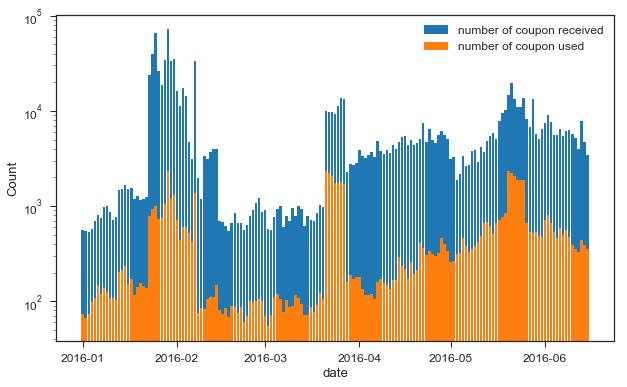

In [6]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)
plt.figure(figsize=(10, 6))
# 时间轴
date_received = train_df['Date_received'].unique()
date_received = sorted(date_received[date_received != 'null'])
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')
plt.bar(date_received_dt, user_receive_coupon['count'], label='number of coupon received')
plt.bar(date_received_dt, user_buy_with_coupon['count'], label='number of coupon used')
# 纵轴使用log的度量
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('date')
plt.legend()
plt.show()

In [7]:
# 分析优惠折扣, 提取折扣信息
def getDiscountType(row):
    if ':' in row:
        return 1
    if '.' in row:
        return 0
    return 'null'

def getDiscountExpire(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountAmount(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def getDiscountRate(row):
    if '.' in row:
        return float(row)
    if ':' in row:
        rows = row.split(':')
        rate = 1 - float(rows[1])/float(rows[0])
        return rate
    else:
        return 1.0


def addDiscountFeatures(df):
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    df['discount_expire'] = df['Discount_rate'].apply(getDiscountExpire)
    df['discount_amount'] = df['Discount_rate'].apply(getDiscountAmount)
    df['discount_rate'] = df['Discount_rate'].apply(getDiscountRate)
    df['distance'] = df['Distance'].replace('null',-1).astype(int)
    return df

In [8]:
# 增加工作日特征
# 获取某一天对应是星期几,1-周一 ... 7-周日
def getWeekdayInfo(row):
    if row != 'null':
        return date(int(row[0:4]),int(row[4:6]),int(row[6:8])).weekday() + 1
    else:
        return row

# 增加weekday特征,若是星期
def addWeekdayFeature(df):
    df['weekday'] = df['Date_received'].astype(str).apply(getWeekdayInfo)
    df['weekday_type'] = df['weekday'].apply(lambda x:1 if x in [6,7] else 0)

    weekday_cols = ['weekday_'+ str(i) for i in range(1,8)]

    # weekday 转化为
    wkdummy = pd.get_dummies(df['weekday'].replace('null',np.nan))
    wkdummy.columns = weekday_cols
    df[weekday_cols] = wkdummy
    return df

# 为数据集添加label, label = 1 代表领取优惠券且已消费,  label = 0代表领取优惠券但是为消费
# label = -1 代表未领取优惠券； label需反映出优惠券对消费的影响
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        #若领取优惠券且也已消费,则判断消费时间是否在领券后的15天以内
        td = pd.to_datetime(row['Date'],format='%Y%m%d') - pd.to_datetime(row['Date_received'],format='%Y%m%d')
        if td <= pd.Timedelta(15,'D'):
            return 1
    return 0

def addLabel(df):
    df['label'] = df.apply(label,axis=1)
    return df

In [9]:
train_df = addLabel(train_df)
train_df = addDiscountFeatures(train_df)
train_df = addWeekdayFeature(train_df)

In [10]:
train_df.tail(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,...,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
1754864,653784,195,null,null,0,null,20160418,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754865,653784,195,null,null,0,null,20160416,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754866,3795296,5341,111,30:5,0,20160129,null,0,1,30,...,0,5,0,0,0,0,0,1,0,0
1754867,188086,6568,null,null,0,null,20160415,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754868,188086,6568,null,null,0,null,20160626,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754869,188086,6568,4723,30:1,0,20160415,null,0,1,30,...,0,5,0,0,0,0,0,1,0,0
1754870,188086,6568,null,null,0,null,20160417,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754871,188086,6568,null,null,0,null,20160604,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754872,212662,3532,null,null,1,null,20160308,-1,null,0,...,1,null,0,0,0,0,0,0,0,0
1754873,212662,2934,5686,30:5,2,20160321,20160330,1,1,30,...,2,1,0,1,0,0,0,0,0,0


In [11]:
# 划分数据集时  将领券时间在20160516之前没有消费的  以及消费时间在20160516之前的数据用来提取特征

In [12]:
feature = train_df[(train_df['Date'] < '20160516')|((train_df['Date'] == 'null') & (train_df['Date_received'] < '20160516'))]

In [13]:
# 领券时间在20160516 到 20160615 之间的数据作为训练/验证集

In [14]:
data = train_df[(train_df['Date_received'] > '20160516') & (train_df['Date_received'] < '20160615')]

In [15]:
from addFeature import userFeature,merchantFeature,usermerchantFeature

In [48]:
userfeature = userFeature(feature)
merchantfeature = merchantFeature(feature)
usermerchantfeature = usermerchantFeature(feature)

['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [17]:
userfeature.head()

,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
0,1439408,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2029232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2223968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data_tv = pd.merge(data,userfeature,how='left',on='User_id').fillna(0)
data_tv = pd.merge(data_tv,merchantfeature,how='left',on='Merchant_id').fillna(0)
data_tv = pd.merge(data_tv,usermerchantfeature,how='left',on=['User_id','Merchant_id']).fillna(0)

In [19]:
pd.set_option('display.max_columns',None)
data_tv.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,discount_amount,discount_rate,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,1439408,4663,11002,150:20,1,20160528,null,0,1,150,20,0.866667,1,6,1,0,0,0,0,0,1,0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1439408,2632,8591,20:1,0,20160613,null,0,1,20,1,0.950000,0,1,0,1,0,0,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085714,0.166667,3.0,1.0,2.0,0.0,0.333333,0.0,0.0
2,2029232,450,1532,30:5,0,20160530,null,0,1,30,5,0.833333,0,1,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42939.0,8574.0,679.0,0.0,10.0,0.862229,0.0,0.015813,0.079193,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,2029232,6459,12737,20:1,0,20160519,null,0,1,20,1,0.950000,0,4,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,2747744,6901,1097,50:10,null,20160606,null,0,1,50,10,0.800000,-1,1,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4705.0,9040.0,407.0,0.0,10.0,0.450128,0.0,0.086504,0.045022,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,196342,1579,10698,20:1,1,20160606,null,0,1,20,1,0.950000,1,1,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,253750,6901,2366,30:5,0,20160518,null,0,1,30,5,0.833333,0,3,0,0,0,1,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4705.0,9040.0,407.0,0.0,10.0,0.450128,0.0,0.086504,0.045022,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,343660,4663,11002,150:20,null,20160528,null,0,1,150,20,0.866667,-1,6,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,1113008,3621,2705,20:5,0,20160524,null,0,1,20,5,0.750000,0,2,0,0,1,0,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3347.0,3963.0,272.0,0.0,10.0,0.564854,0.0,0.081267,0.068635,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,1113008,2277,1495,30:10,0,20160523,null,0,1,30,10,0.666667,0,1,0,1,0,0,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,199.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [20]:
userfeature[userfeature['User_id']==2029232]

,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
2,2029232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  领券日期在20160516到20160615之间数据划分为训练/验证集

In [21]:
train,valid = train_test_split(data_tv,stratify=data_tv['label'],random_state=100)

In [22]:
weekdaycols = ['weekday_' + str(i) for i in range(1, 8)]
original_feature = ['discount_rate', 'discount_type', 'discount_expire', 'discount_amount', 'distance', 'weekday',
                    'weekday_type'] + weekdaycols
predictors = original_feature+userfeature.columns.tolist()[1:]+merchantfeature.columns.tolist()[1:]+usermerchantfeature.columns.tolist()[1:]

In [23]:
train.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,discount_amount,discount_rate,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
143991,3941599,797,9044,30:5,0,20160529,null,0,1,30,5,0.833333,0,7,1,0,0,0,0,0,0,1,6.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2155.0,2808.0,401.0,0.0,10.0,0.424501,0.0,0.186079,0.142806,3.0,0.0,3.0,0.0,0.00,0.00,0.0
93029,3248622,8614,332,30:5,null,20160520,null,0,1,30,5,0.833333,-1,5,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,883.0,705.0,85.0,0.0,10.0,1.600000,0.0,0.096263,0.120567,0.0,0.0,0.0,0.0,0.00,0.00,0.0
199745,5517033,760,2418,30:5,1,20160610,null,0,1,30,5,0.833333,1,5,0,0,0,0,0,1,0,0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.000000,0.500000,13628.0,10156.0,857.0,0.0,10.0,0.382064,0.0,0.062885,0.084384,0.0,0.0,0.0,0.0,0.00,0.00,0.0
109459,6425948,7717,3563,20:1,2,20160609,null,0,1,20,1,0.950000,2,4,0,0,0,0,1,0,0,0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3824.0,4639.0,218.0,0.0,10.0,1.142857,0.0,0.057008,0.046993,0.0,0.0,0.0,0.0,0.00,0.00,0.0
171380,4776856,6901,2107,30:5,0,20160528,null,0,1,30,5,0.833333,0,6,1,0,0,0,0,0,1,0,19.0,9.0,1.0,4.0,1.0,1.0,1.0,1.0,0.052632,0.111111,4705.0,9040.0,407.0,0.0,10.0,0.450128,0.0,0.086504,0.045022,4.0,3.0,1.0,0.0,0.75,0.00,0.0
18262,929934,7555,2111,0.8,3,20160523,20160524,1,0,0,0,0.800000,3,1,0,1,0,0,0,0,0,0,4.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,0.250000,1.000000,26983.0,7946.0,1222.0,0.0,10.0,1.220426,0.0,0.045288,0.153788,4.0,1.0,4.0,1.0,0.25,0.25,1.0
236605,3813128,450,1613,30:5,null,20160602,null,0,1,30,5,0.833333,-1,4,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,42939.0,8574.0,679.0,0.0,10.0,0.862229,0.0,0.015813,0.079193,0.0,0.0,0.0,0.0,0.00,0.00,0.0
34152,1931387,1244,5136,30:10,0,20160526,null,0,1,30,10,0.666667,0,4,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,128.0,208.0,1.0,1.0,1.0,1.000000,1.0,0.007812,0.004808,0.0,0.0,0.0,0.0,0.00,0.00,0.0
181469,182436,4663,11002,150:20,2,20160528,null,0,1,150,20,0.866667,2,6,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,0.0,0.0,0.0,0.0,0.00,0.00,0.0
14423,2066693,450,1532,30:5,0,20160530,null,0,1,30,5,0.833333,0,1,0,1,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,42939.0,8574.0,679.0,0.0,10.0,0.862229,0.0,0.015813,0.079193,0.0,0.0,0.0,0.0,0.00,0.00,0.0


In [24]:
def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

In [25]:
if not os.path.isfile('model_1.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('model_1.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    # 训练集和验证集的划分是按固定的时间划分的,因此第一次训练好的模型之后可以直接用
    with open('model_1.pkl', 'rb') as f:
        model = pickle.load(f)

In [26]:
valid_tmp = valid.copy()
valid_tmp['pred_prob'] = model.predict_proba(valid_tmp[predictors])[:,1]
valid_tmp.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,discount_amount,discount_rate,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate,pred_prob
212169,3081611,4579,12852,5:1,0,20160526,20160601,1,1,5,1,0.800000,0,4,0,0,0,0,1,0,0,0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,0.000000,235.0,1979.0,55.0,0.0,9.0,1.057692,0.0,0.234043,0.027792,2.0,2.0,0.0,0.0,1.000000,0.0,0.0,0.174566
188667,4059286,4447,1843,10:1,null,20160610,null,0,1,10,1,0.900000,-1,5,0,0,0,0,0,1,0,0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.000000,4.0,13.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.126986
147909,4626243,760,2418,30:5,1,20160613,null,0,1,30,5,0.833333,1,1,0,1,0,0,0,0,0,0,5.0,6.0,1.0,4.0,0.0,0.0,0.0,0.0,0.20,0.166667,13628.0,10156.0,857.0,0.0,10.0,0.382064,0.0,0.062885,0.084384,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.060235
205597,6195585,3958,7754,20:1,0,20160517,null,0,1,20,1,0.950000,0,2,0,0,1,0,0,0,0,0,8.0,24.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,0.000000,32.0,75.0,9.0,0.0,8.0,2.000000,0.0,0.281250,0.120000,19.0,15.0,4.0,0.0,0.789474,0.0,0.0,0.274641
214775,5694366,4663,11002,150:20,null,20160528,null,0,1,150,20,0.866667,-1,6,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018849
87100,7269200,7679,4385,30:5,0,20160521,20160527,1,1,30,5,0.833333,0,6,1,0,0,0,0,0,1,0,13.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.000000,1314.0,1651.0,221.0,0.0,2.0,0.138095,0.0,0.168189,0.133858,13.0,10.0,3.0,0.0,0.769231,0.0,0.0,0.189225
72818,65220,611,2851,20:5,0,20160525,null,0,1,20,5,0.750000,0,3,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,438.0,703.0,71.0,0.0,10.0,0.615385,0.0,0.162100,0.100996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.070371
202471,4271133,629,2427,30:10,0,20160524,null,0,1,30,10,0.666667,0,2,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,246.0,331.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.084575
104547,5657828,991,11612,100:30,2,20160518,null,0,1,100,30,0.700000,2,3,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,6.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.048932
231439,6204455,760,2418,30:5,0,20160607,null,0,1,30,5,0.833333,0,2,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,13628.0,10156.0,857.0,0.0,10.0,0.382064,0.0,0.062885,0.084384,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.054815


In [41]:
from sklearn.metrics import roc_auc_score
pred = model.predict(valid_tmp[predictors])
roc_auc_score(pred,valid_tmp['label'])

0.7697701174132201

In [27]:
validgroup = valid_tmp.groupby(['Coupon_id'])
print('after groupby')
validgroup.head()

after groupby


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,discount_amount,discount_rate,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate,pred_prob
212169,3081611,4579,12852,5:1,0,20160526,20160601,1,1,5,1,0.800000,0,4,0,0,0,0,1,0,0,0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,235.0,1979.0,55.0,0.0,9.0,1.057692,0.0,0.234043,0.027792,2.0,2.0,0.0,0.0,1.000000,0.000000,0.000000,0.174566
188667,4059286,4447,1843,10:1,null,20160610,null,0,1,10,1,0.900000,-1,5,0,0,0,0,0,1,0,0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.0,13.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.126986
147909,4626243,760,2418,30:5,1,20160613,null,0,1,30,5,0.833333,1,1,0,1,0,0,0,0,0,0,5.0,6.0,1.0,4.0,0.0,0.0,0.0,0.0,0.200000,0.166667,13628.0,10156.0,857.0,0.0,10.0,0.382064,0.0,0.062885,0.084384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.060235
205597,6195585,3958,7754,20:1,0,20160517,null,0,1,20,1,0.950000,0,2,0,0,1,0,0,0,0,0,8.0,24.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,32.0,75.0,9.0,0.0,8.0,2.000000,0.0,0.281250,0.120000,19.0,15.0,4.0,0.0,0.789474,0.000000,0.000000,0.274641
214775,5694366,4663,11002,150:20,null,20160528,null,0,1,150,20,0.866667,-1,6,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.018849
87100,7269200,7679,4385,30:5,0,20160521,20160527,1,1,30,5,0.833333,0,6,1,0,0,0,0,0,1,0,13.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1314.0,1651.0,221.0,0.0,2.0,0.138095,0.0,0.168189,0.133858,13.0,10.0,3.0,0.0,0.769231,0.000000,0.000000,0.189225
72818,65220,611,2851,20:5,0,20160525,null,0,1,20,5,0.750000,0,3,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,438.0,703.0,71.0,0.0,10.0,0.615385,0.0,0.162100,0.100996,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.070371
202471,4271133,629,2427,30:10,0,20160524,null,0,1,30,10,0.666667,0,2,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,246.0,331.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.084575
104547,5657828,991,11612,100:30,2,20160518,null,0,1,100,30,0.700000,2,3,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,6.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.048932
231439,6204455,760,2418,30:5,0,20160607,null,0,1,30,5,0.833333,0,2,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,13628.0,10156.0,857.0,0.0,10.0,0.382064,0.0,0.062885,0.084384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.054815


In [28]:
aucs = []
for i in validgroup:
    tmpdf = i[1]
    # 同一个Coupon_id的优惠券有可能被多个用户领取，如果这些用户都消费了或者都没消费则认为参数对预测不起作用
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

0.6224537780234521


In [29]:
validgroup.get_group('10')['label'].unique().__len__()

2

###  使用xgboost

In [30]:
from xgboost.sklearn import XGBClassifier

In [31]:
cls = XGBClassifier(max_depth=6,min_samples_split=10,min_samples_leaf=5,max_features=0.7)

##### data_tv中null替换为0 Object对象改为int

In [32]:
data_tv1 = data_tv.copy()
data_tv1 = data_tv1.drop(['Discount_rate','Distance'],axis=1)
data_tv1[['Coupon_id','Date','Date_received']] = data_tv1[['Coupon_id','Date','Date_received']].replace('null',0)
data_tv1[['Coupon_id','Date','Date_received']] = data_tv1[['Coupon_id','Date','Date_received']].astype('int')

In [33]:
train,valid = train_test_split(data_tv1,stratify=data_tv['label'],random_state=100)
Y_train = train['label']
X_train = train.drop('label',axis=1)

In [34]:
 X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183014 entries, 143991 to 108175
Data columns (total 45 columns):
User_id                    183014 non-null int64
Merchant_id                183014 non-null int64
Coupon_id                  183014 non-null int32
Date_received              183014 non-null int32
Date                       183014 non-null int32
discount_type              183014 non-null int64
discount_expire            183014 non-null int64
discount_amount            183014 non-null int64
discount_rate              183014 non-null float64
distance                   183014 non-null int32
weekday                    183014 non-null int64
weekday_type               183014 non-null int64
weekday_1                  183014 non-null uint8
weekday_2                  183014 non-null uint8
weekday_3                  183014 non-null uint8
weekday_4                  183014 non-null uint8
weekday_5                  183014 non-null uint8
weekday_6                  183014 non-null uint8


In [35]:
cls.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, max_features=0.7, min_child_weight=1,
       min_samples_leaf=5, min_samples_split=10, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [36]:
y_valid = valid['label']
x_valid = valid.drop(['label'],axis=1)
y_pred = cls.predict_proba(x_valid)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid,y_pred)

0.9999432295739912

In [39]:
y_pred

array([9.9730957e-01, 2.3469415e-04, 2.3469415e-04, ..., 2.3469415e-04,
       2.9767281e-04, 2.9767281e-04], dtype=float32)

####  预测封装并提交数据

In [46]:
off_test = pd.read_csv('../data/ccf_offline_stage1_test_revised.csv')
off_test1 = addDiscountFeatures(off_test)
off_test1 = addWeekdayFeature(off_test1)

In [49]:
# userfeature = userFeature(off_test1)
# merchantfeature = merchantFeature(off_test1)
# usermerchantfeature = usermerchantFeature(off_test1)
off_test2 = pd.merge(off_test1,userfeature,how='left',on='User_id').fillna(0)
off_test2 = pd.merge(off_test2,merchantfeature,how='left',on='Merchant_id').fillna(0)
off_test2 = pd.merge(off_test2,usermerchantfeature,how='left',on=['User_id','Merchant_id']).fillna(0)

In [51]:
off_test2 = off_test2.drop(['Discount_rate','Distance'],axis=1)
off_test2[['Coupon_id','Date_received']] = off_test2[['Coupon_id','Date_received']].replace('null',0)
off_test2[['Coupon_id','Date_received']] = off_test2[['Coupon_id','Date_received']].astype('int')

In [52]:
result_pred = cls.predict_proba(off_test2,predictors)[:,1]

ValueError: feature_names mismatch: ['User_id', 'Merchant_id', 'Coupon_id', 'Date_received', 'Date', 'discount_type', 'discount_expire', 'discount_amount', 'discount_rate', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate'] ['User_id', 'Merchant_id', 'Coupon_id', 'Date_received', 'discount_type', 'discount_expire', 'discount_amount', 'discount_rate', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
expected Date in input data